In [55]:
import cv2
import numpy as np
import dlib
import matplotlib.pyplot as plt

import math

In [59]:
# Loading an image and converting colour space while accounting for bgr in jupyter
images = ('./test_images/jason_momoa.png', './test_images/jason_momoa_left.jpg', './test_images/jason_momoa_right.jpg')
frame = cv2.imread(images[1])
display_frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
display_copy = display_frame.copy()
gray_frame = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
rows, columns, _ = np.shape(frame)
data_type = frame.dtype

whiskers = cv2.imread('./filters/whiskers.png', cv2.IMREAD_UNCHANGED)
whisker_rows, whisker_columns, depth = np.shape(whiskers)

filter_layer = np.zeros((rows, columns, depth), data_type)

In [57]:
# Pose estimation
stored_camera_matrix = []

def get_camera_matrix(facial_image, new_image=True):
    """
    Estimate camera matrix based on image dimensions
    :param facial_image: image containing the single object (face) for which we are estimating pose
    """
    global stored_camera_matrix
    if new_image:
        # Estimate camera parameters
        frame_size = np.shape(facial_image)
        width = frame_size[1]
        height = frame_size[0]
        # Approximate optical centre with the centre of the image
        optical_centre = (width / 2, height / 2)
        # Approximate focal length with the width of the image in pixels
        focal_length = frame_size[1]
        # Camera matrix expressed as 3x3 matrix including focal length (fx,fy) and optical centers (cx,cy)
        # | fx  0   cx |
        # | 0   fy  cy |
        # | 0   0   1  |
        camera_matrix = np.array(
            [
                [focal_length, 0, optical_centre[0]],
                [0, focal_length, optical_centre[1]],
                [0, 0, 1]
            ],
            dtype="double",
        )
        # Save camera matrix for image dimensions
        stored_camera_matrix = camera_matrix
        # Return constructed matrix
        return camera_matrix
    else:
        # Return previously constructed matrix
        return stored_camera_matrix

def get_distortion_coefficients():
    """
    Returns an array of zeros under assumption that there is no radial distortion
    :return distortion_coeffs: a 4x1 array of zeros
    """
    # Assume radial distortion does not exist
    distortion_coeffs = np.zeros((4, 1))
    return distortion_coeffs

def calculate_pose(facial_image, facial_points_2D):
    """
    Calculate the translational and rotational matrices associated with direction of a face in an image
    :param facial_image: image containing the single object (face) for which we are estimating pose
    :param facial_points_2D: numpy array containing corresponding 2D points in facial image for 3D points listed below 
        (A) nose tip, (B) chin, (C) left eye left corner, (D) right eye right corner, (E) left mouth corner, (F) right mouth corner
        68 landmark points: (A) 30, (B) 8, (C) 36, (D) 45, (E) 48, (F) 54
    """
    # Estimate 3D points
    facial_points_3D = np.array(
        [
            (0.0, 0.0, 0.0),  # Nose tip
            (0.0, -330.0, -65.0),  # Chin
            (-225.0, 170.0, -135.0),  # Left eye left corner
            (225.0, 170.0, -135.0),  # Right eye right corner
            (-150.0, -150.0, -125.0),  # Left mouth corner
            (150.0, -150.0, -125.0)  # Right mouth corner
        ]
    )
    # Get camera matrix
    camera_matrix = get_camera_matrix(facial_image)
    # Get distortion coefficients
    distortion_coeffs = get_distortion_coefficients()

    success, rotation_vector, translation_vector = cv2.solvePnP(facial_points_3D, facial_points_2D, camera_matrix, distortion_coeffs, flags=0)
    
    if success:
        return (rotation_vector, translation_vector)
    else:
        return -1


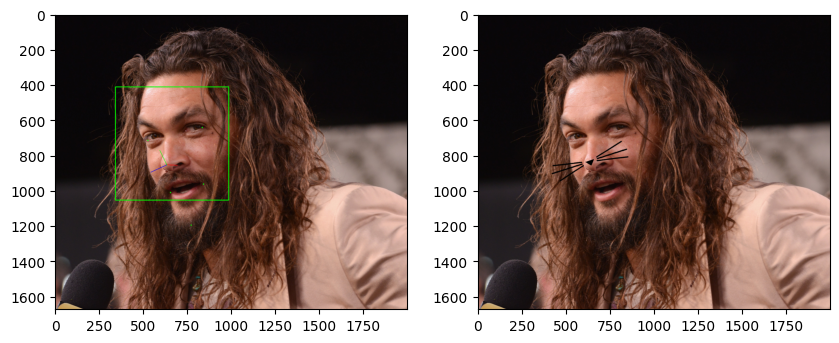

In [60]:
# Initialize dlib's face detector
detector = dlib.get_frontal_face_detector()

# Detect faces in the grayscale image
faces = detector(gray_frame)

# Find boundaries and draw bounding box
face = faces[0]
x1 = face.left()
y1 = face.top()
x2 = face.right()
y2 = face.bottom()

# Drawing a rectangle around the face
border_colour = (0,255,0)
border_width = 3
cv2.rectangle(display_copy, (x1,y1), (x2,y2), border_colour, border_width)

# Find landmarks
predictor = dlib.shape_predictor("shape_predictor_68_face_landmarks.dat")
landmarks = predictor(gray_frame, face)
nosetip = (landmarks.part(30).x, landmarks.part(30).y)
noseleft = (landmarks.part(31).x, landmarks.part(31).y)
noseright = (landmarks.part(35).x, landmarks.part(35).y)
nose_width = abs(noseleft[0] - noseright[0])

# Adjust overlay
whisker_width = int(4 * nose_width)
whisker_height = int((whisker_rows / whisker_columns) * whisker_width)
half_height = whisker_height // 2
half_width = whisker_width // 2

resized_whiskers = cv2.resize(whiskers, (whisker_width, whisker_height))

filter_layer[nosetip[1] - half_height : nosetip[1] + half_height, nosetip[0] - half_width : nosetip[0] + half_width] = resized_whiskers

# Account for pose estimation
facial_points_2D = np.array(
    # (A) 30, (B) 8, (C) 36, (D) 45, (E) 48, (F) 54
    [
        (landmarks.part(30).x, landmarks.part(30).y),  # Nose tip
        (landmarks.part(8).x, landmarks.part(8).y),  # Chin
        (landmarks.part(36).x, landmarks.part(36).y),  # Left eye left corner
        (landmarks.part(45).x, landmarks.part(45).y),  # Right eye right corner
        (landmarks.part(48).x, landmarks.part(48).y),  # Left mouth corner
        (landmarks.part(54).x, landmarks.part(54).y)  # Right mouth corner
    ],
    dtype="double",
)
# Check points match expected locations
for point in facial_points_2D:
    cv2.circle(display_copy, (int(point[0]), int(point[1])), 2, border_colour, border_width)

# Calculate pose matrices
transformation_vectors = calculate_pose(display_copy, facial_points_2D)
if transformation_vectors != -1:
    # Display pose direction
    rotation_vector = transformation_vectors[0]
    translation_vector = transformation_vectors[1]
    camera_matrix = get_camera_matrix(display_copy, new_image=False)
    dist_coeffs = get_distortion_coefficients()
    # Convert three 3D points, each along a different axis
    point_x, _ = cv2.projectPoints(np.array([(100.0, 0.0, 0.0)]), rotation_vector, translation_vector, camera_matrix, dist_coeffs)
    point_y, _ = cv2.projectPoints(np.array([(0.0, 100.0, 0.0)]), rotation_vector, translation_vector, camera_matrix, dist_coeffs)
    point_z, _ = cv2.projectPoints(np.array([(0.0, 0.0, 100.0)]), rotation_vector, translation_vector, camera_matrix, dist_coeffs)
    point_x = np.array(point_x).flatten()
    point_y = np.array(point_y).flatten()
    point_z = np.array(point_z).flatten()
    # Draw lines showing axes
    x_colour = (255, 0, 0) # red
    y_colour = (0, 255, 0) # green
    z_colour = (0, 0, 255) # blue
    line_width = 2
    # Get points
    origin_point = nosetip
    point_x_coordinates = (int(point_x[0]), int(point_x[1]))
    point_y_coordinates = (int(point_y[0]), int(point_y[1]))
    point_z_coordinates = (int(point_z[0]), int(point_z[1]))
    cv2.line(display_copy, origin_point, point_x_coordinates, x_colour, line_width)
    cv2.line(display_copy, origin_point, point_y_coordinates, y_colour, line_width)
    cv2.line(display_copy, origin_point, point_z_coordinates, z_colour, line_width)
    # Adjust filter position
    centre = nosetip
    M = cv2.getRotationMatrix2D(centre, math.degrees(rotation_vector[1].item()), 1)
    filter_layer_rotated = cv2.warpAffine(filter_layer, M, (columns, rows))
else:
    print("Could not get pose estimation")

# Create mask from resized overlay and extract rgb channels
alpha_channel = filter_layer_rotated[:, :, 3] // 255
inverse_alpha_channel = np.bitwise_not(alpha_channel) // 255

overlay_colors = filter_layer_rotated[:, :, :3]
display_whiskers = cv2.cvtColor(overlay_colors, cv2.COLOR_BGR2RGB)

# Apply masks to images
masked_whiskers = cv2.bitwise_and(display_whiskers, display_whiskers, mask=alpha_channel)
masked_frame = cv2.bitwise_and(display_frame, display_frame, mask=inverse_alpha_channel)

# Add the images 
final_frame = cv2.add(masked_frame, masked_whiskers)

fig = plt.figure(figsize=(10, 10))
fig.add_subplot(1, 2, 1) 
plt.imshow(display_copy) 
fig.add_subplot(1, 2, 2) 
plt.imshow(final_frame) 
